# Deterministic Real-Business Cycle Model 

The economy consists of a number of identical households. The optimal growth problem in discrete time with no uncertainty can be written as follows:
$$
\begin{eqnarray}
 \max_{ \{ c(t), k(t) \}_{t=0}^{\infty} }
 \sum_{t=0}^{\infty}
 \beta^t
 u(c(t))
\end{eqnarray}
$$
subject to
$$
\begin{eqnarray}
 k(t+1) = f(k(t)) + (1-\delta)k(t) - c(t)
\end{eqnarray}
$$
with $k(t) \geq 0$ and given $k(0) > 0$.

Rewriting the optimal growth problem as a dynamic programming  problem. Let the choice (or control) variable be next date's capital stock, denoted $s$. Then the resource constraint, shown in the optimal growth problem, implies that the current consumption is given by $$c=f(k)+(1-\delta)k-s$$

The optimal growth problem can be written in the following recursive form:
$$
V(k) = \max_{ s\in G(k) } 
\{
 u( f(k) + (1-\delta)k - s ) + \beta V(s)
\}
$$
where $G(k)$ is the constraint correspondence, given by the interval $[0, f(k)+(1-\delta)k]$. This constraint requires that consumption and the capital stock be nonnegative.

The functional form used in the implementation below is:
$$
\begin{eqnarray}
 u(c(t)) = \log(c(t))    
\end{eqnarray}
$$
and 
$$
\begin{eqnarray}
 f(k) = k^{\alpha}
\end{eqnarray}
$$


The first-order conditions for this problem are given by:
$$
\begin{eqnarray}
 u'(c(t)) = \beta u'(c(t+1)) [ f'(k(t)) + 1 - \delta ] \\
 f(k(t)) + (1-\delta)k(t) - k(t+1) - c(t) = 0
\end{eqnarray}
$$

In [81]:
# Load packages
using Optim
using Plots
using Statistics
using NLsolve

In [82]:
# Functions
function fun_max(mX)
    # Find maximum of a matrix along the columns
    # Input: mX of dimension m x n
    # Output vMax of dimension n
    iCols = size(mX, 2);
    vMax = zeros(iCols,1);
    for i = 1:iCols
            temp_max = findmax( mX[:,i] );
            vMax[i] = temp_max[1];
    end
    return vMax;
end

function fun_max_index(mX)
    # Find maximum of a matrix along the columns
    # and give the index
    # Input: mX of dimension m x n
    # Output vMax of dimension n
    iCols = size(mX, 2);
    vMax_index = zeros(iCols,1);
    for i = 1:iCols
            temp_max = findmax( mX[:,i] );
            vMax_index[i] = temp_max[2];
    end
    return vMax_index;
end

fun_max_index (generic function with 1 method)

In [83]:
# Structural parameters
pAlpha = 0.8;
pBeta = 0.92;
pDelta = 0.8;

In [84]:
# Analytical steady state
dKss_an = ( (1-pBeta*(1-pDelta))/pBeta )^(1/pAlpha);
dCss_an = dKss_an^pAlpha+(1-pDelta)*dKss_an-dKss_an;
display(dKss_an)
display(dCss_an)

0.8607517498331757

0.19835512187258975

In [85]:
# Computing the steady state values
PARAMS = [ pAlpha, pDelta, pBeta ];
function f!(F,x,PARAMS)

    # 1  2  
    # c, k

    pAlpha = PARAMS[1];
    pDelta = PARAMS[2];
    pBeta  = PARAMS[3];
    
    c = x[1];
    k = x[2];
    
    uc = 1/c
    fk = k^pAlpha
    
    F[1] = pBeta*uc*( fk + 1 - pDelta ) - uc
    F[2] = fk + (1-pDelta)*k - k - c
    
end


SteadyState = nlsolve((F,x) ->f!(F,x,PARAMS), [ dCss_an, dKss_an ], iterations = 1000 , method = :newton)

# Defining the steady state
dCss = SteadyState.zero[1];
dKss = SteadyState.zero[2];

display(dKss)
display(dCss)


0.8607517498331757

0.19835512187258975

In [86]:
# Algorithm related parameters
iIter = 5000;
iGridPointsK = 30;
iToler = 10e-6;

# Constructing the grid
dKmin = dKss * 0.9;
dKmax = dKss * 1.1;


iStepK = (dKmax-dKmin) / (iGridPointsK-1);
vK = collect(dKmin:iStepK:dKmax);
iGridPointsK = size(vK,1);

#display(vK)

In [87]:
mK_S = zeros(iGridPointsK, iGridPointsK);

# Storage space
for idxKP = 1:iGridPointsK
    for idxK = 1:iGridPointsK
        mK_S[idxKP,idxK] = vK[idxK];
    end
end

mK = mK_S;
mKP = mK';


mC = mK.^pAlpha + (1-pDelta).*mK - mK;

#display( mC )

In [88]:
# Eliminate negative consumption
mCP = mC .> 0;
mPC = ones(iGridPointsK, iGridPointsK) - mCP;
z = 10e-5;
mC = mC.*mCP + z*mPC;

# Initialize value function
mU = log.( mC ) ;

mCF = mC;

mVNew = log.(mCF);
global vVOld = fun_max( mU+pBeta*mVNew ); # ( [iGridPointsK*iGridPointsN] x 1 )


vEps = zeros(iIter,1);

In [89]:
global counter = 0;
### Main Iteration - BEGIN ###
for idxIter=1:iIter

 global vVOld;
 global  counter;

 vVNew = fun_max(mU+pBeta*(ones(iGridPointsK,1)*vVOld')');

 iDiff = ( abs.(vVOld-vVNew) ) ./ vVOld;

 dEps = sum(sqrt.((iDiff).^2));
 vEps[idxIter,1] = dEps;

 if sum(sqrt.((iDiff).^2)) <= iToler
  vVOld = vVNew;
  break
 else
  vVOld = vVNew;
 end
 
 counter = counter + 1;

end
### Main Iteration - END ###

print("\n");
print("\n");
print("Iterations needed to reach convergence : ")
print(counter);
print("\n");



Iterations needed to reach convergence : 147


In [90]:
plot(vEps[100:iIter],legend=false,title="Convergence of the value iteration")
xlabel!("iterations")
ylabel!("epsilon")

# Preparing maximum values and indices for policy function
maxR = fun_max(mU+pBeta*(ones(iGridPointsK,1)*vVOld')');
idxR = fun_max_index(mU+pBeta*(ones(iGridPointsK,1)*vVOld')');

print("Maximum value");
print("\n");
print(maxR);
print("\n");
print("\n");
print("Index")
print("\n");
print(idxR);
print("\n");
print("\n");
print("Capital grid");
print("\n");
print(vK);
print("\n");
print("\n");


Maximum value
[-20.15386316864416; -20.152611023716478; -20.15139916642774; -20.150227102323022; -20.149094349460032; -20.148000438042562; -20.146944910067756; -20.14592731898658; -20.14494722937695; -20.14400421662892; -20.14309786664144; -20.14222777553018; -20.141393549345953; -20.14059480380329; -20.139831164018727; -20.13910226425844; -20.13840774769478; -20.137747266171402; -20.137120479976613; -20.136527057624587; -20.135966675644198; -20.135439018375063; -20.134943777770626; -20.13448065320791; -20.13404935130373; -20.133649585737132; -20.133281077077726; -20.13294355261983; -20.13263674622207; -20.132360398152304]

Index
[30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0; 30.0]

Capital grid
[0.7746765748498582, 0.7806127938142249, 0.7865490127785917, 0.7924852317429584, 0.7984214507073251, 0.8043576696716919, 0.8102938886360586, 0.8162301076004252, 0.8221

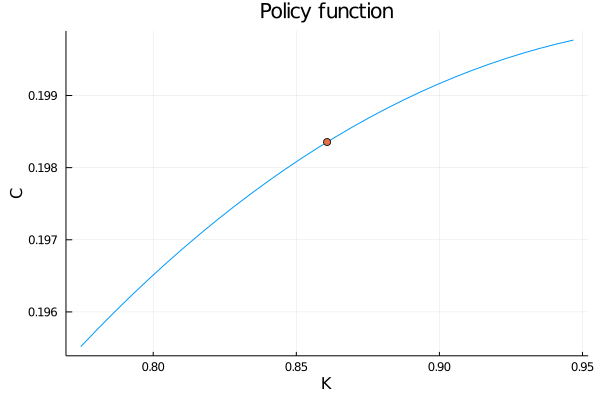

In [103]:
print("\n");
print("\n");

# Extending the grid where we evaluate variables
vK_L = vK ;

policyC = ones(iGridPointsK,1);

for idx = 1:iGridPointsK
    policyC[idx] = mC[ floor(Int, idxR[idx]) , idx ]
end

plot(vK_L, policyC, title="Policy function", legend=false)
scatter!([dKss],[dCss])
xlabel!("K")
ylabel!("C")


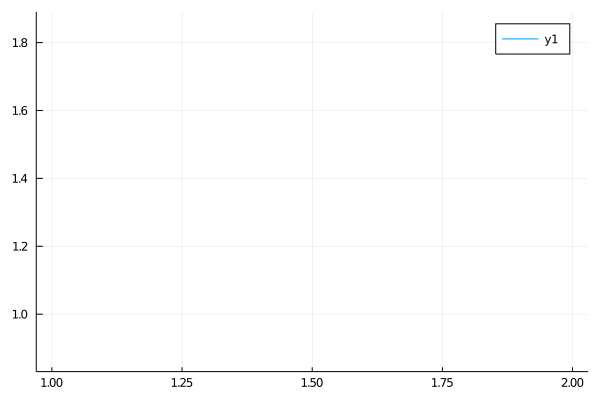